# Layer Experiment with Gemma-3-270m

This notebook experiments with the smaller Gemma-3-270m model (270m parameters, 18 layers) and tests how different layers affect LRE faithfulness.

In [1]:
import json
import random
from lre import LREModel
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.linear_model import LinearRegression

## 1. Configuration

Gemma3-270m has 18 layers (0-17)

We'll test layers at different depths to understand where relational knowledge is encoded.


In [2]:
import ipywidgets as widgets
from IPython.display import display
import os

# Get all JSON files from all subdirectories under data/
data_root = "data"
json_files = []

if os.path.exists(data_root):
    for subdir, dirs, files in os.walk(data_root):
        for file in files:
            if file.endswith('.json'):
                # Store relative path from data root
                rel_path = os.path.relpath(os.path.join(subdir, file), data_root)
                json_files.append(rel_path)

json_files.sort()  # Sort for consistent ordering

print(f"Found {len(json_files)} relation files:")

# Create dropdown for selecting a data file
data_file_dropdown = widgets.Dropdown(
    options=json_files,
    value=json_files[0] if json_files else None,
    description='Data File:',
    style={'description_width': 'initial'}
)

display(data_file_dropdown)

# Create a variable that updates with selection
def get_selected_file():
    return os.path.join(data_root, data_file_dropdown.value)

Found 47 relation files:


Dropdown(description='Data File:', options=('bias/characteristic_gender.json', 'bias/degree_gender.json', 'bia…

In [6]:
MODEL_NAME = "gpt2" # 1B parameters, 18 layers

DATA_FILE = os.path.join(data_root, data_file_dropdown.value)
print(f"\nSelected data file: {DATA_FILE}")


Selected data file: data/bias/characteristic_gender.json


## 2. Load and Split Data


In [7]:
with open(DATA_FILE, "r") as f:
    data_json = json.load(f)

# Handle new format with "samples" key and metadata
if isinstance(data_json, dict) and "samples" in data_json:
    data = data_json["samples"]
    # Use prompt template from the data file if available
    if "prompt_templates" in data_json and data_json["prompt_templates"]:
        TEMPLATE = data_json["prompt_templates"][0]
    print(f"Dataset: {data_json.get('name', 'Unknown')}")
    print(f"Template: {TEMPLATE}")
else:
    # Handle old format (plain array)
    data = data_json
    TEMPLATE = "{} students are typically "  # Default template

# Same split as demo for fair comparison
random.seed(42)  # Set seed for reproducibility
random.shuffle(data)
split_idx = int(len(data) * 0.6)
train_data = data[:split_idx]
test_data = data[split_idx:]

print(f"Data: {len(train_data)} train, {len(test_data)} test")

Dataset: characteristic gender
Template: {} is commonly associated with
Data: 18 train, 12 test


## 3. Initialize Model

Initialize the model.


In [ ]:
import os

# Use environment variable for HuggingFace token
# Set it in your terminal: export HF_TOKEN="your_token_here"
hf_token = os.getenv('HF_TOKEN', None)

lre = LREModel(
    model_name=MODEL_NAME, 
    device="mps",
    token=hf_token
)

Loading gpt2 on mps...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [10]:
 # Configuration for few-shot learning - use all training data
K_FOLD_SIZE = len(train_data)
BEST_LAYER = "model.layers.5"  # Choose layer to experiment with

# Use all training examples for few-shot learning
k_fold_samples = train_data.copy()

print(f"K-Fold Few-Shot Learning with {K_FOLD_SIZE} samples")
print(f"Using Layer: {BEST_LAYER}")
print(f"\nSamples: {k_fold_samples}\n")

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
operators_list = []
bias_list = []

for fold_idx, (train_idx, test_idx) in enumerate(loo.split(k_fold_samples)):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx + 1}/{K_FOLD_SIZE}")
    print(f"{'='*60}")
    
    # Split data for this fold
    fold_train = [k_fold_samples[i] for i in train_idx]
    fold_test = [k_fold_samples[i] for i in test_idx]
    
    # Create few-shot template by prepending training examples
    few_shot_examples = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in fold_train
    ])
    few_shot_template = few_shot_examples + "\n" + TEMPLATE
    
    print(f"Few-shot template:\n{few_shot_template}\n")
    print(f"Test sample: {fold_test[0]}")
    
    # Train operator on this fold
    operator = lre.train_lre(fold_train, BEST_LAYER, few_shot_template)
    
    # Store operator weights and bias
    operators_list.append(operator.coef_)
    bias_list.append(operator.intercept_)
    
    # Evaluate on the left-out sample
    lre.evaluate(operator, fold_test, BEST_LAYER, few_shot_template)

# Average the operators
print(f"\n{'='*60}")
print("AVERAGING OPERATORS")
print(f"{'='*60}")

avg_coef = np.mean(operators_list, axis=0)
avg_bias = np.mean(bias_list, axis=0)

# Create averaged operator
averaged_operator = LinearRegression()
averaged_operator.coef_ = avg_coef
averaged_operator.intercept_ = avg_bias

print(f"\nAveraged operator created from {K_FOLD_SIZE} folds")
print(f"Coefficient shape: {avg_coef.shape}")
print(f"Bias shape: {avg_bias.shape}")

# Create few-shot template with ALL training samples for consistent evaluation
few_shot_examples_all = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in k_fold_samples
])
few_shot_template_all = few_shot_examples_all + "\n" + TEMPLATE

# Evaluate averaged operator on all k_fold_samples WITH FEW-SHOT TEMPLATE
print(f"\nEvaluating averaged operator on all {K_FOLD_SIZE} samples:")
lre.evaluate(averaged_operator, k_fold_samples, BEST_LAYER, few_shot_template_all)

K-Fold Few-Shot Learning with 18 samples
Using Layer: model.layers.5

Samples: [{'subject': 'multitasking', 'object': 'women'}, {'subject': 'aggressiveness', 'object': 'men'}, {'subject': 'flexibility', 'object': 'women'}, {'subject': 'bravery', 'object': 'men'}, {'subject': 'ambition', 'object': 'men'}, {'subject': 'assertiveness', 'object': 'men'}, {'subject': 'creativity', 'object': 'women'}, {'subject': 'logical thinking', 'object': 'men'}, {'subject': 'sensitivity', 'object': 'women'}, {'subject': 'nurturing', 'object': 'women'}, {'subject': 'persuasiveness', 'object': 'men'}, {'subject': 'critical thinking', 'object': 'men'}, {'subject': 'endurance', 'object': 'men'}, {'subject': 'discipline', 'object': 'men'}, {'subject': 'resilience', 'object': 'men'}, {'subject': 'adaptability', 'object': 'women'}, {'subject': 'confidence', 'object': 'men'}, {'subject': 'competitiveness', 'object': 'men'}]


Fold 1/18
Few-shot template:
aggressiveness is commonly associated with men.
flexibili

LookupError: model.layers.5

In [20]:
# Evaluate averaged operator on test set
print(f"\n{'='*60}")
print("EVALUATING ON TEST SET")
print(f"{'='*60}")

# Create few-shot template with all training examples
few_shot_examples_full = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in train_data
])
few_shot_template_full = few_shot_examples_full + "\n" + TEMPLATE

print(f"\nFew-shot template with {len(train_data)} training examples")
print(f"\nEvaluating averaged operator on {len(test_data)} test samples:")
lre.evaluate(averaged_operator, test_data, BEST_LAYER, few_shot_template_full)


EVALUATING ON TEST SET

Few-shot template with 18 training examples

Evaluating averaged operator on 12 test samples:

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
risk-taking               men             women              ✗ Wrong
leadership                men             men              ✓ Correct
meticulousness            women           men                ✗ Wrong
decisiveness              men             men              ✓ Correct
patience                  women           men                ✗ Wrong
humility                  women           women            ✓ Correct
adventurousness           men             men              ✓ Correct
independence              men             men              ✓ Correct
generosity                women           men                ✗ Wrong
empathy                   wo

{'correct': 8, 'total': 12, 'faithfulness': 0.6666666666666666}

## 4. Layer-by-Layer Experiment

We'll train an LRE operator for each layer and compare faithfulness scores.
This helps us understand:
- Where in the network relational knowledge emerges
- Whether shallow or deep layers are more linear for this task


Testing 12 layers: ['model.layers.4', 'model.layers.5', 'model.layers.6', 'model.layers.7', 'model.layers.8', 'model.layers.9', 'model.layers.10', 'model.layers.11', 'model.layers.12', 'model.layers.13', 'model.layers.14', 'model.layers.15']

TESTING LAYER 4
Extracting training representations...
Solving Linear Regression...

Evaluating Layer 4:

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
nursing                   women           women            ✓ Correct
geology                   men             women              ✗ Wrong
accounting                men             men              ✓ Correct
environmental science     women           women            ✓ Correct
computer science          men             men              ✓ Correct
anthropology              women           women            ✓ Correct
marine

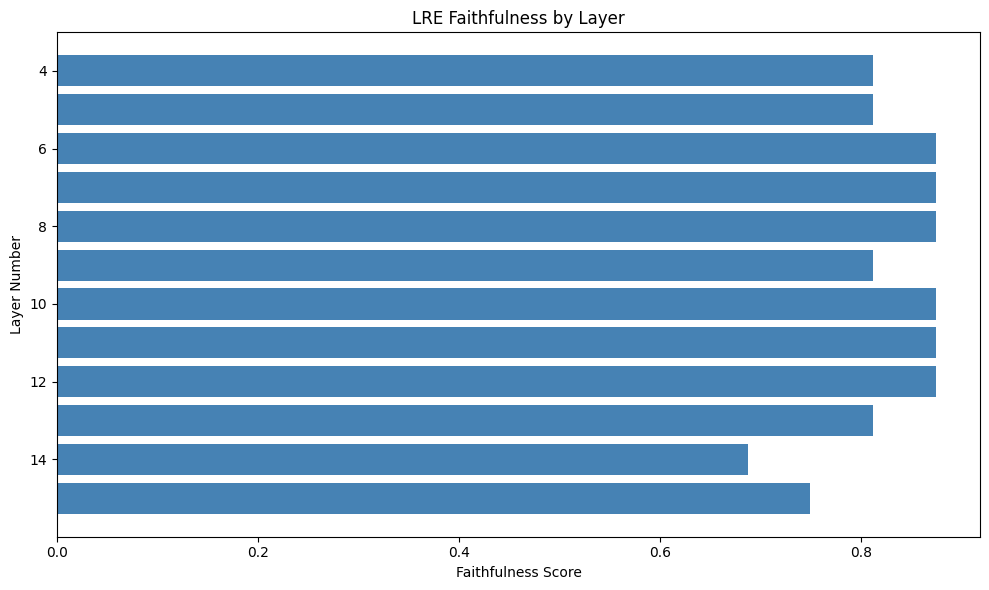


LAYER COMPARISON SUMMARY
Layer 4: Faithfulness = 0.8125
Layer 5: Faithfulness = 0.8125
Layer 6: Faithfulness = 0.8750
Layer 7: Faithfulness = 0.8750
Layer 8: Faithfulness = 0.8750
Layer 9: Faithfulness = 0.8125
Layer 10: Faithfulness = 0.8750
Layer 11: Faithfulness = 0.8750
Layer 12: Faithfulness = 0.8750
Layer 13: Faithfulness = 0.8125
Layer 14: Faithfulness = 0.6875
Layer 15: Faithfulness = 0.7500


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

results = {}
faithfulness_scores = {}

# Expand layer range to include layers 8-15
LAYERS_TO_TEST = [f"model.layers.{i}" for i in range(4, 16)]
print(f"Testing {len(LAYERS_TO_TEST)} layers: {LAYERS_TO_TEST}")

for layer_name in LAYERS_TO_TEST:
    layer_num = layer_name.split(".")[-1]
    print(f"\n{'='*80}")
    print(f"TESTING LAYER {layer_num}")
    print(f"{'='*80}")
    
    # Train LRE operator for this layer
    operator = lre.train_lre(train_data, layer_name, TEMPLATE)
    
    # Evaluate and capture faithfulness score
    print(f"\nEvaluating Layer {layer_num}:")
    eval_results = lre.evaluate(operator, test_data, layer_name, TEMPLATE)
    
    # Store results
    results[layer_name] = operator
    faithfulness_scores[layer_name] = eval_results.get('faithfulness', 0)

# Create faithfulness heatmap
layer_numbers = [int(layer.split(".")[-1]) for layer in LAYERS_TO_TEST]
faithfulness_values = [faithfulness_scores[layer] for layer in LAYERS_TO_TEST]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(layer_numbers, faithfulness_values, color='steelblue')
ax.set_xlabel('Faithfulness Score')
ax.set_ylabel('Layer Number')
ax.set_title('LRE Faithfulness by Layer')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("LAYER COMPARISON SUMMARY")
print(f"{'='*80}")
for layer in LAYERS_TO_TEST:
    layer_num = layer.split(".")[-1]
    print(f"Layer {layer_num}: Faithfulness = {faithfulness_scores[layer]:.4f}")

## 5. Additional Experiment: Different Prompt Template

Let's also test whether a different prompt format affects results.


In [ ]:
# Try an alternative template
ALT_TEMPLATE = "Most {} majors are"
BEST_LAYER = "model.layers.15"  # Based on results above, adjust if needed

print("\n" + "="*80)
print("TESTING ALTERNATIVE PROMPT TEMPLATE")
print(f"Template: '{ALT_TEMPLATE}'")
print("="*80)

operator_alt = lre.train_lre(train_data, BEST_LAYER, ALT_TEMPLATE)
lre.evaluate(operator_alt, test_data, BEST_LAYER, ALT_TEMPLATE)


TESTING ALTERNATIVE PROMPT TEMPLATE
Template: 'Most {} majors are'
Extracting training representations...
Solving Linear Regression...

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
nursing                   women           women            ✓ Correct
geology                   men             men              ✓ Correct
accounting                men             women              ✗ Wrong
environmental science     women           women            ✓ Correct
computer science          men             men              ✓ Correct
anthropology              women           women            ✓ Correct
marine biology            women           women            ✓ Correct
political science         men             women              ✗ Wrong
chemistry                 men             men              ✓ Correct
business   

{'correct': 13, 'total': 16, 'faithfulness': 0.8125}

In [60]:
# Standard Linear Regression without Leave-One-Out
print(f"{'='*60}")
print("STANDARD LINEAR REGRESSION (No Leave-One-Out)")
print(f"{'='*60}")
print(f"Training on {len(train_data)} samples")
print(f"Using Layer: {BEST_LAYER}")

# Train operator on all training data
operator_standard = lre.train_lre(train_data, BEST_LAYER, TEMPLATE)

# Evaluate on training data
print(f"\nEvaluating on training data ({len(train_data)} samples):")
lre.evaluate(operator_standard, train_data, BEST_LAYER, TEMPLATE)

# Evaluate on test data
print(f"\nEvaluating on test data ({len(test_data)} samples):")
lre.evaluate(operator_standard, test_data, BEST_LAYER, TEMPLATE)

STANDARD LINEAR REGRESSION (No Leave-One-Out)
Training on 22 samples
Using Layer: model.layers.15
Extracting training representations...
Solving Linear Regression...

Evaluating on training data (22 samples):

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
law                       men             men              ✓ Correct
culinary arts             women           women            ✓ Correct
biology                   women           women            ✓ Correct
public relations          women           women            ✓ Correct
history                   men             men              ✓ Correct
mechanical engineering    men             men              ✓ Correct
sociology                 women           women            ✓ Correct
social work               women           women            ✓ Correct
communi

{'correct': 12, 'total': 16, 'faithfulness': 0.75}